In [1]:
import pandas as pd
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam, Optimizer
from functools import reduce
from matplotlib import pyplot as plt

# Обработка данных

In [4]:
# Чтение данных в pandas Dataframe
def read_csv(patch: str) -> tuple:
    data = pd.read_csv(patch)

    return (data["password"], data["strength"])

# Разделение слов-паролей на токены-символы
def tokenizer(words: list[str]) -> list[list[str]]:
    for index, word in enumerate(words):
        words[index] = list(word)

    return words

# Конвертирование паролей в токены
def convertPassword(passwords: pd.Series) -> list[list[str]]:
    passwords = passwords.to_list()
    tokens = tokenizer(passwords)

    return tokens

# Конвертирование силы пароля в Тензор
def convertStrength(strength: pd.Series) -> torch.Tensor:
    return torch.tensor(strength.to_list())

# Функция merged_list принимает списки из списков токенов, а возвращает одномерный списков токенов
merged_list = lambda lists: reduce(lambda result, lst: result.extend(lst) or result, lists, [])

In [5]:
patch = "passwords.csv"
passwords, strength = read_csv(patch)

# Посмотрим распределение классов
print(strength.value_counts())
# Данные сильно дисбалансированны
# Напишем код для функции ошибки, которая возвращает вес для каждого класса
weights = len(strength) / strength.value_counts()
weight_classes = torch.tensor([
    weights[0],
    weights[1],
    weights[2]
], dtype=torch.float)
print(weight_classes)

1    74278
0    13428
2    12294
Name: strength, dtype: int64
tensor([7.4471, 1.3463, 8.1340])


In [6]:
# Посчитаем количество уникальных символов
tokens = tokenizer(passwords.to_list())
unique_tokens = set(merged_list(tokens))
num_unique_tokens = len(unique_tokens) + 1 # Неизвестный токен (<unk>) +1

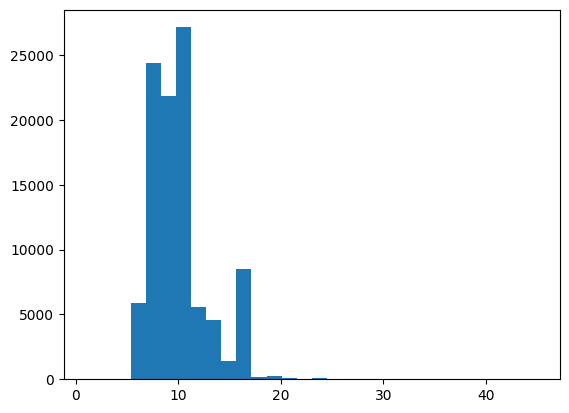

In [7]:
# Построим график длин всех паролей
len_passwords = passwords.apply(lambda x: len(x))
f = len_passwords.to_list()
plt.hist(f, bins=30)
plt.show()
# На глаз длинна пароля в 10 символов достаточно
max_seq_length = 10

In [8]:
# Класс словаря, для сопоставленния токенов с числами
class Vocab:
    def __init__(self, data: list = None) -> None:
        self.tokens = {"<unk>": 0}
        if data is not None:
            self.addNewTokens(data)

    def __call__(self, tokens: list[list[str]]) -> torch.Tensor:
        replace = lambda token: self[token]

        for index, word in enumerate(tokens):
            word = list(map(replace, word)) # Заменить каждый токен-сомвол на его числовую форму
            tokens[index] = torch.tensor(word, dtype=torch.long)

        # Заполнить каждый вектор с числовым представлением нулями, неизвестный токен == 0.
        # Длинна заполнения == самый длинный пароль
        return nn.utils.rnn.pad_sequence(tokens, padding_value=0)

    def __getitem__(self, token: str) -> int:
        if token not in self.tokens:
            return 0

        return self.tokens[token]

    def addNewTokens(self, tokens: list[list[str]]):
        unique_tokens = set(merged_list(tokens)) # Уникальные токены
        for token in unique_tokens:
            # Добавляем каждый уникальный, ещё не добавленый, токен в словарь
            if token in self.tokens:
                continue
            self.tokens[token] = len(self.tokens)

        return self

    def save(self, patch: str):
        torch.save(self.tokens, patch)

        return self

    @staticmethod
    def load(patch: str):
        tokens = torch.load(patch)
        vocab = Vocab()
        vocab.tokens = tokens

        return vocab

In [9]:
class PasswordDataset(Dataset):
    def __init__(self,
                 passwords: list[list[str]],
                 strength: torch.Tensor,
                 vocab: Vocab,
                 max_seq_length: int) -> None:
        # Обрезать последовательность до максимальной длинны
        self.passwords = vocab(passwords)[:max_seq_length]
        self.strength = strength

    def __len__(self) -> int:
        return self.passwords.shape[1]

    def __getitem__(self, key: int) -> tuple[torch.Tensor, torch.Tensor]:
        return (self.passwords[:, key], self.strength[key])

In [10]:
# Собираем все вместе для удобства использования
def load_data(patch: str,
              max_seq_length: int,
              batch_size: int,
              shuffle: bool) -> tuple:
    passwords, strength = read_csv(patch)
    passwords = convertPassword(passwords)
    strength = convertStrength(strength)
    vocab = Vocab(passwords)
    kws_dataset = {
        "passwords": passwords,
        "strength": strength,
        "vocab": vocab,
        "max_seq_length": max_seq_length,
    }
    kws_dataloader = {
        "dataset": PasswordDataset(**kws_dataset),
        "batch_size": batch_size,
        "shuffle": shuffle,
    }
    return (DataLoader(**kws_dataloader), vocab)

# Постраение модели

In [11]:
# Я решил использовать модель на основе Transformer
# Плюсы трансформера в сравнении с рекурентными сетями это отсутствие взрывные/исчезающих градиентов
class PasswordAI(nn.Module):
    def __init__(self,
                 num_embeddings: int,
                 embedding_dim: int,
                 nhead: int,
                 max_seq_length: int) -> None:
        super().__init__()
        self._positional_encoding(embedding_dim, max_seq_length)
        self.properties = {
            "num_embeddings": num_embeddings,
            "embedding_dim": embedding_dim,
            "nhead": nhead,
            "max_seq_length": max_seq_length,
        }
        # Вложения слов
        self.emb = nn.Embedding(num_embeddings,
                                embedding_dim,
                                padding_idx=0)
        # Слой энкодера
        self.transformer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=nhead,
            batch_first=True,
        )
        # Классификатор
        self.classifier = nn.Sequential(
            nn.Linear(embedding_dim, 3), nn.LogSoftmax(-1),
        )

    def forward(self, passwords) -> torch.Tensor:
        x = self.emb(passwords) + self.pe
        out = self.transformer(x)[:, -1, :]

        return self.classifier(out)

    def _positional_encoding(self, embedding_dim: int, max_seq_length: int) -> None:
        # Обучаемые позиционные кодировки для вложений слов
        pe = torch.zeros(max_seq_length, embedding_dim)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embedding_dim, 2).float() * -(9.21 / embedding_dim))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = nn.Parameter(pe)

    def save(self, patch: str):
        torch.save([self.properties, self.state_dict()], patch)

        return self

    @staticmethod
    def load(patch: str):
        properties, parameters = torch.load(patch)
        model = PasswordAI(**properties)
        model.load_state_dict(parameters)

        return model

# Обучение модели

In [12]:
# Функция обучения модели
def train(model: PasswordAI,
          optimizer: Optimizer,
          data: DataLoader,
          weight_classes: torch.Tensor,
          epochs: int,
          device: str) -> None:
    weight_classes = weight_classes.to(device)
    model.to(device)
    model.train()

    for epoch in range(1, epochs+1):
        error = 0

        for batch, (x, y) in enumerate(data, 1):
            x, y, = x.to(device), y.to(device)
            predict = model(x)
            loss = F.nll_loss(predict, y, weight_classes) # LogLoss хорошо подходит для данных с дисбалансом классов
            loss.backward()
            error += loss.item()
            optimizer.step()
            optimizer.zero_grad()

            if batch % 500 == 0:
                print(f'losses: {error/batch:.3f} | batch: {batch}/{len(data)} | epoch: {epoch}')

    print("\ntraining completed")

In [13]:
kws_model = {
    "num_embeddings": num_unique_tokens,
    "embedding_dim": 100,
    "nhead": 5,
    "max_seq_length": max_seq_length,
}
AI = PasswordAI(**kws_model)

kws_optim = {
    "params": AI.parameters(),
    "lr": 1e-4,
    "betas": (0.9, 0.999),
    "weight_decay": 1e-4, # L2 регуляризация для предотвращения переобучения
}
optim = Adam(**kws_optim)

kws_data = {
    "patch": "passwords.csv",
    "max_seq_length": kws_model["max_seq_length"],
    "batch_size": 100,
    "shuffle": True,
}
data, vocab = load_data(**kws_data)

kws_train = {
    "model": AI,
    "optimizer": optim,
    "data": data,
    "weight_classes": weight_classes,
    "epochs": 20,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
}
train(**kws_train)

AI.save("model.weight.pt")
vocab.save("vocab.pt")

losses: 0.266 | batch: 500/1000 | epoch: 1
losses: 0.196 | batch: 1000/1000 | epoch: 1
losses: 0.106 | batch: 500/1000 | epoch: 2
losses: 0.100 | batch: 1000/1000 | epoch: 2
losses: 0.084 | batch: 500/1000 | epoch: 3
losses: 0.084 | batch: 1000/1000 | epoch: 3
losses: 0.079 | batch: 500/1000 | epoch: 4
losses: 0.078 | batch: 1000/1000 | epoch: 4
losses: 0.075 | batch: 500/1000 | epoch: 5
losses: 0.073 | batch: 1000/1000 | epoch: 5
losses: 0.072 | batch: 500/1000 | epoch: 6
losses: 0.070 | batch: 1000/1000 | epoch: 6
losses: 0.066 | batch: 500/1000 | epoch: 7
losses: 0.067 | batch: 1000/1000 | epoch: 7
losses: 0.067 | batch: 500/1000 | epoch: 8
losses: 0.065 | batch: 1000/1000 | epoch: 8
losses: 0.062 | batch: 500/1000 | epoch: 9
losses: 0.064 | batch: 1000/1000 | epoch: 9
losses: 0.060 | batch: 500/1000 | epoch: 10
losses: 0.061 | batch: 1000/1000 | epoch: 10
losses: 0.060 | batch: 500/1000 | epoch: 11
losses: 0.060 | batch: 1000/1000 | epoch: 11
losses: 0.059 | batch: 500/1000 | epoch

# Проверка своего пароля

In [14]:
# Перевод из 3 классов надёжности в одно непрерывное число
def class_to_reliability(classes: torch.Tensor) -> float:
    device = classes.device
    weight = torch.tensor([0.0, 0.5, 1.0]).to(device)
    return (classes * weight).sum(-1).item()

# Показать в удобном виде надёжность пароля
def print_reliability(strength: float) -> None:
    txt = "Надёжность пароля - "
    if strength < 0.5: txt += "слабый"
    elif strength >= 0.5 and strength <= 0.75: txt += "средний"
    else: txt += "сильный"

    x = int(20 * strength)
    scale = "#" * x + "~" * (20 - x)
    print(txt)
    print(scale + f" ({strength*100:.1f}%)\n")

# Функция для проверки своего пароля на надёжность
def check_password(password: str,
                   model: PasswordAI,
                   vocab: Vocab,
                   device: str = "cpu") -> float:
    model.eval().to(device)
    max_len = model.properties["max_seq_length"]
    password = vocab(tokenizer([password]))[:max_len]
    if password.size(0) < max_len:
        zero = torch.zeros(max_len-password.size(0), 1, dtype=torch.long)
        password = torch.cat([password, zero], 0)

    password = password.transpose(1, 0).to(device)
    predict = F.softmax(model(password)[0], -1)

    strength = class_to_reliability(predict)
    print_reliability(strength)

    return strength

In [15]:
test = [
    "nurik2004", # Обычный пароль
    "9HcL", # Короткий пароль
    "Хелоу_мир!", # Русских букв в Датасете не было
    "Def Inf", # Пробелы очень плохо влияют на надёжность
    "H6g79fh7B8", # Хороший пароль
]
AI = PasswordAI.load("model.weight.pt")
vocab = Vocab.load("vocab.pt")

for x in test:
    print(x)
    check_password(x, AI, vocab)

nurik2004
Надёжность пароля - средний
##########~~~~~~~~~~ (50.0%)

9HcL
Надёжность пароля - слабый
~~~~~~~~~~~~~~~~~~~~ (0.0%)

Хелоу_мир!
Надёжность пароля - средний
#############~~~~~~~ (69.3%)

Def Inf
Надёжность пароля - слабый
~~~~~~~~~~~~~~~~~~~~ (0.0%)

H6g79fh7B8
Надёжность пароля - сильный
###################~ (98.9%)

